<a href="https://colab.research.google.com/github/Heoyuna0819/machine_learning/blob/main/WISDM_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#1. Load & Clean
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
df = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt",
                 header=None, names=names, comment=';')

df = df.drop(columns=["NaN"])
# 문자 제거 후 숫자로 변환
for col in ["x_axis", "y_axis", "z_axis"]:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(";", "", regex=True), errors="coerce")
df = df.dropna().reset_index(drop=True)

In [ ]:
#2. Train/Test Split (user 기준)
df_train = df[df["user_id"] <= 20].copy()
df_test  = df[(df["user_id"] > 20) & (df["user_id"] <= 36)].copy()

In [ ]:
#3. Scaling
scale_cols = ["x_axis", "y_axis", "z_axis"]
scaler = RobustScaler().fit(df_train[scale_cols])
df_train.loc[:, scale_cols] = scaler.transform(df_train[scale_cols])
df_test.loc[:, scale_cols]  = scaler.transform(df_test[scale_cols])


In [ ]:
#4. Label Encoding
le = LabelEncoder()
df_train["activity_enc"] = le.fit_transform(df_train["activity"])
df_test["activity_enc"]  = le.transform(df_test["activity"])


In [ ]:
#5. Sliding Window
def create_windows(X_df, y_ser, time_steps=200, step=40):
    X, y = [], []
    for i in range(0, len(X_df) - time_steps, step):
        block = X_df.iloc[i:i+time_steps].values
        labels = y_ser.iloc[i:i+time_steps].values
        # 최빈값 라벨
        vals, cnts = np.unique(labels, return_counts=True)
        major = vals[np.argmax(cnts)]
        X.append(block)
        y.append(major)
    return np.asarray(X), np.asarray(y).reshape(-1, 1)


TIME_STEPS, STEP = 128, 20
X_train_all, y_train_all = create_windows(df_train[scale_cols], df_train["activity_enc"],
                                          time_steps=TIME_STEPS, step=STEP)
X_test, y_test = create_windows(df_test[scale_cols], df_test["activity_enc"],
                                time_steps=TIME_STEPS, step=STEP)

In [ ]:
# 6. Train/Valid Split
y_flat = y_train_all.flatten()
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_all, y_flat, test_size=0.2, random_state=42, stratify=y_flat
)

In [ ]:
# 7. One-Hot Encoding
enc = OneHotEncoder(sparse_output=False)
y_tr_oh  = enc.fit_transform(y_tr.reshape(-1, 1))
y_val_oh = enc.transform(y_val.reshape(-1, 1))
y_test_oh = enc.transform(y_test.reshape(-1, 1))

n_timesteps, n_features = X_tr.shape[1], X_tr.shape[2]
n_classes = y_tr_oh.shape[1]
print("Input shape:", (n_timesteps, n_features), "Classes:", n_classes, le.classes_)


Input shape: (128, 3) Classes: 6 ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']


In [ ]:
# 8. LSTM 모델
inputs = keras.Input(shape=(n_timesteps, n_features))
x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=False, activation="tanh",
                          recurrent_dropout=0.1)
    )(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(n_classes, activation="softmax")(x)

optimizer = keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)

model = keras.Model(inputs, outputs)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,974 (171.77 KB)

 Trainable params: 43,718 (170.77 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# 9. Callbacks
early = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")
rlr   = keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")

In [ ]:
# 10. Train
history = model.fit(
    X_tr, y_tr_oh,
    validation_data=(X_val, y_val_oh),
    epochs=50,
    batch_size=32,
    callbacks=[early, rlr],
    verbose=1
)


Epoch 1/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 190s 236ms/step - accuracy: 0.6562 - loss: 1.0164 - val_accuracy: 0.8182 - val_loss: 0.5090 - learning_rate: 5.0000e-04
Epoch 2/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 196s 229ms/step - accuracy: 0.8153 - loss: 0.5134 - val_accuracy: 0.8649 - val_loss: 0.3444 - learning_rate: 5.0000e-04
Epoch 3/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 206s 235ms/step - accuracy: 0.8514 - loss: 0.3991 - val_accuracy: 0.8708 - val_loss: 0.3467 - learning_rate: 5.0000e-04
Epoch 4/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 199s 231ms/step - accuracy: 0.8744 - loss: 0.3288 - val_accuracy: 0.8975 - val_loss: 0.2713 - learning_rate: 5.0000e-04
Epoch 5/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 199s 227ms/step - accuracy: 0.8879 - loss: 0.2950 - val_accuracy: 0.9153 - val_loss: 0.2175 - learning_rate: 5.0000e-04
Epoch 6/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 205s 231ms/step - accuracy: 0.9064 - loss: 0.2508 - val_accuracy: 0.9263 - val_loss: 0.2127 - learning_rate: 5.0000e-04
Epoch 7/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 

742/742 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step

Classification Report (Test):
              precision    recall  f1-score   support

  Downstairs       0.69      0.66      0.67      2444
     Jogging       0.90      0.97      0.93      7512
     Sitting       0.94      0.83      0.88      1122
    Standing       0.88      0.80      0.84      1064
    Upstairs       0.64      0.74      0.69      2844
     Walking       0.91      0.84      0.87      8755

    accuracy                           0.85     23741
   macro avg       0.83      0.81      0.82     23741
weighted avg       0.85      0.85      0.85     23741



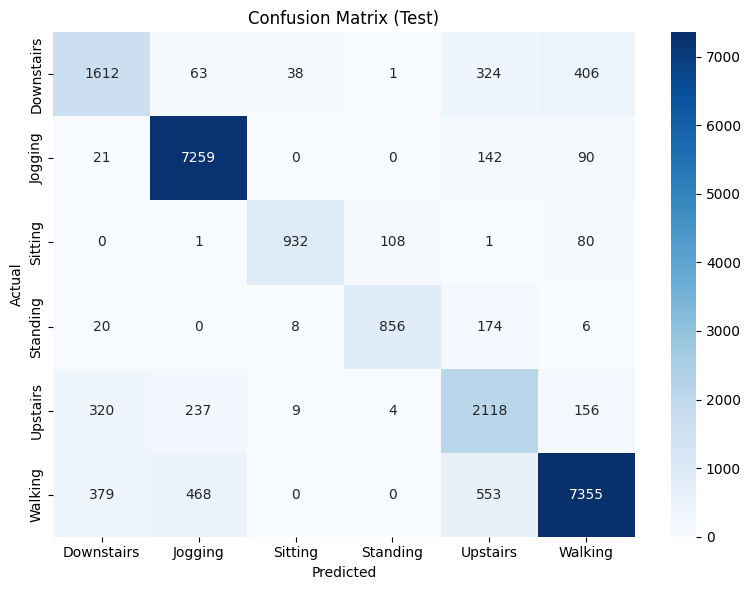

In [ ]:
# 11. Evaluate
y_pred_prob = model.predict(X_test, batch_size=32)
y_pred = y_pred_prob.argmax(axis=1)

print("\nClassification Report (Test):")
print(classification_report(y_test.flatten(), y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test.flatten(), y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()